In [2]:
import os
import time
import uuid
import cv2
import albumentations as alb

In [9]:
!labelme

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [118]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [119]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [10]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img


In [121]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [122]:
for image in os.listdir(os.path.join('Data','Images')):
    img = cv2.imread(os.path.join('Data', 'Images', image))

    height, width, channels = img.shape
    coords = [0,0,0.00001,0.00001]
    label_path = os.path.join('Data', 'Labels', f'{image.split(".")[0]}.json')
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            label = json.load(f)

        coords[0] = label['shapes'][0]['points'][0][0]
        coords[1] = label['shapes'][0]['points'][0][1]
        coords[2] = label['shapes'][0]['points'][1][0]
        coords[3] = label['shapes'][0]['points'][1][1]
        coords = list(np.divide(coords, [width,height,width,height]))

    try: 
        for x in range(60):
            augmented = augmentor(image=img, bboxes=[coords], class_labels=['Bowie'])
            cv2.imwrite(os.path.join('aug_data', 'Images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

            annotation = {}
            annotation['image'] = image

            if os.path.exists(label_path):
                if len(augmented['bboxes']) == 0: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 
                else: 
                    annotation['bbox'] = augmented['bboxes'][0]
                    annotation['class'] = 1
            else: 
                annotation['bbox'] = [0,0,0,0]
                annotation['class'] = 0 


            with open(os.path.join('aug_data', 'Labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                json.dump(annotation, f)

    except Exception as e:
        print(e)


IndexError: list index out of range

In [11]:
images = tf.data.Dataset.list_files(['aug_data\\Images\\*.jpg', 'aug_data\\Images\\*.jpeg'], shuffle=False)
labels = tf.data.Dataset.list_files(['aug_data\\Labels\\*.json'], shuffle=False)

In [12]:
images = list(images.as_numpy_iterator())
labels = list(labels.as_numpy_iterator())

In [13]:
train_images, temp_test_data, train_labels, temp_test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
test_images, val_images, test_labels, val_labels = train_test_split(temp_test_data, temp_test_labels, test_size=0.3, random_state=42)

In [14]:
train_images = tf.data.Dataset.from_tensor_slices(train_images)
train_labels = tf.data.Dataset.from_tensor_slices(train_labels)
test_images = tf.data.Dataset.from_tensor_slices(test_images)
test_labels = tf.data.Dataset.from_tensor_slices(test_labels)
val_images = tf.data.Dataset.from_tensor_slices(val_images)
val_labels = tf.data.Dataset.from_tensor_slices(val_labels)

In [15]:
h,w = 224, 224

In [16]:
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (w,h)))
train_images = train_images.map(lambda x: x/255)

In [17]:
type(train_images)

tensorflow.python.data.ops.dataset_ops.MapDataset

In [146]:
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (w,h)))
test_images = test_images.map(lambda x: x/255)

In [147]:
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (w,h)))
val_images = val_images.map(lambda x: x/255)

In [148]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [149]:
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [150]:
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [151]:
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [152]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(3408, 3408, 596, 596, 256, 256)

In [153]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(32)
train = train.prefetch(4)

In [154]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(32)
test = test.prefetch(4)

In [155]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(32)
val = val.prefetch(4)

In [156]:
data_samples = train.as_numpy_iterator()

In [157]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


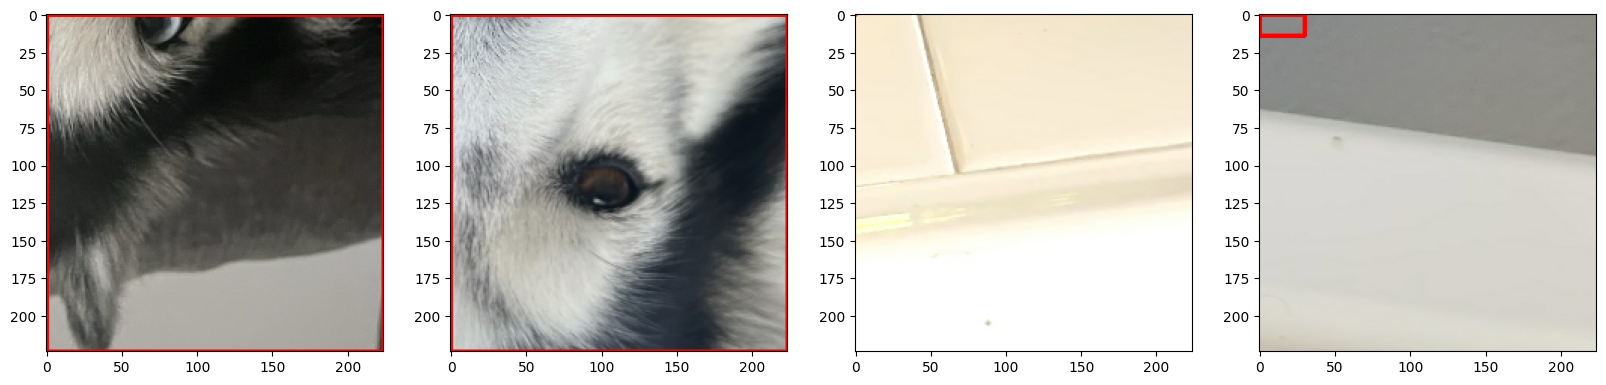

In [158]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [w,h]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [w,h]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

In [159]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [160]:
vgg = VGG16(include_top=False)

In [161]:
def build_model(): 
    input_layer = Input(shape=(w,h,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [162]:
bowietracker = build_model()

In [163]:
bowietracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [164]:
X, y = train.as_numpy_iterator().next()

In [165]:
X.shape

(32, 224, 224, 3)

In [166]:
classes, coords = bowietracker.predict(X)

1/1 [==============================] - 22s 22s/step


In [167]:
classes, coords

(array([[0.57804936],
        [0.579823  ],
        [0.4326061 ],
        [0.6135006 ],
        [0.4464699 ],
        [0.531864  ],
        [0.5215137 ],
        [0.51220846],
        [0.5983775 ],
        [0.47644538],
        [0.46908078],
        [0.464177  ],
        [0.49388948],
        [0.47855437],
        [0.55757517],
        [0.4095401 ],
        [0.54758966],
        [0.3879657 ],
        [0.5883482 ],
        [0.5934496 ],
        [0.41942847],
        [0.48966077],
        [0.45562422],
        [0.5100989 ],
        [0.5713807 ],
        [0.5919852 ],
        [0.5020926 ],
        [0.37455907],
        [0.5358532 ],
        [0.46323603],
        [0.5816374 ],
        [0.5937746 ]], dtype=float32),
 array([[0.41509008, 0.66060543, 0.6074015 , 0.43741497],
        [0.27721953, 0.77960896, 0.70177233, 0.44608903],
        [0.26636755, 0.79939044, 0.6898259 , 0.49441928],
        [0.3124596 , 0.693897  , 0.7047657 , 0.39488104],
        [0.23655422, 0.71795374, 0.71233934, 0.

In [168]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [169]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

In [170]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [171]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [172]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=41.45504>

In [173]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7685821>

In [174]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=41.45504>

In [175]:
class BowieTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [176]:
model = BowieTracker(bowietracker)

In [177]:
model.compile(opt, classloss, regressloss)

In [178]:
logdir='logs'

In [179]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [185]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_total_loss', patience=5, restore_best_weights=True)

In [239]:
hist = model.fit(train, epochs=15, validation_data=val, callbacks=[early_stopping])

Epoch 1/15
  1/107 [..............................] - ETA: 3:11:46 - total_loss: 0.1307 - class_loss: 0.0010 - regress_loss: 0.1302

KeyboardInterrupt: 

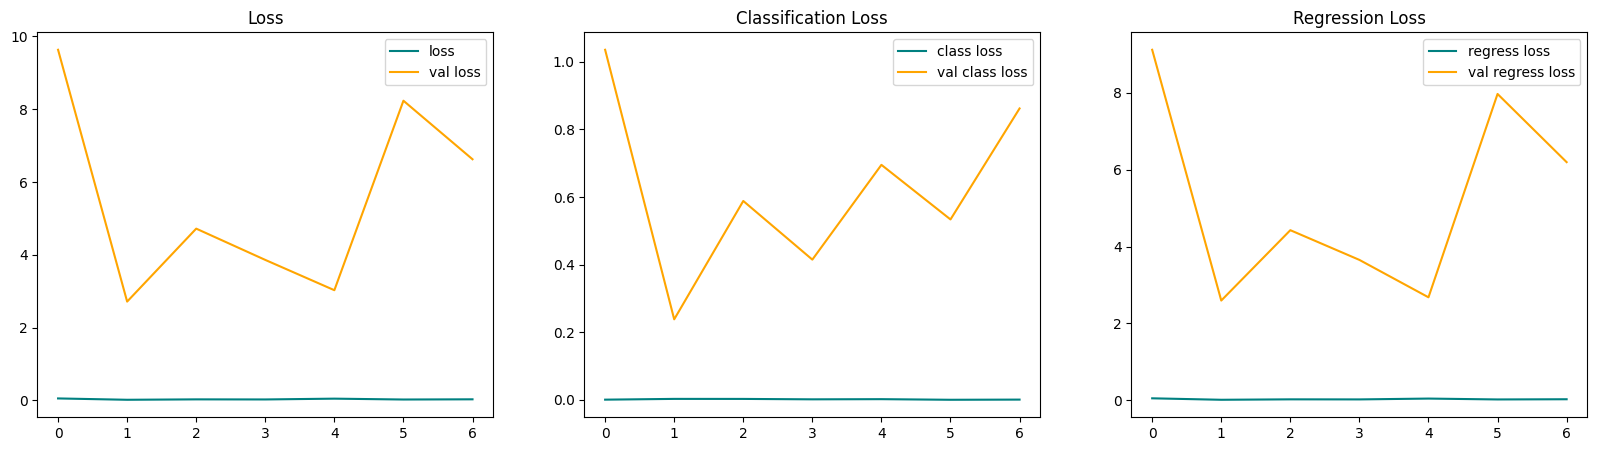

In [187]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [230]:
test_data = test.as_numpy_iterator()

In [231]:
test_sample = test_data.next()

In [232]:
yhat = bowietracker.predict(test_sample[0])

1/1 [==============================] - 0s 25ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


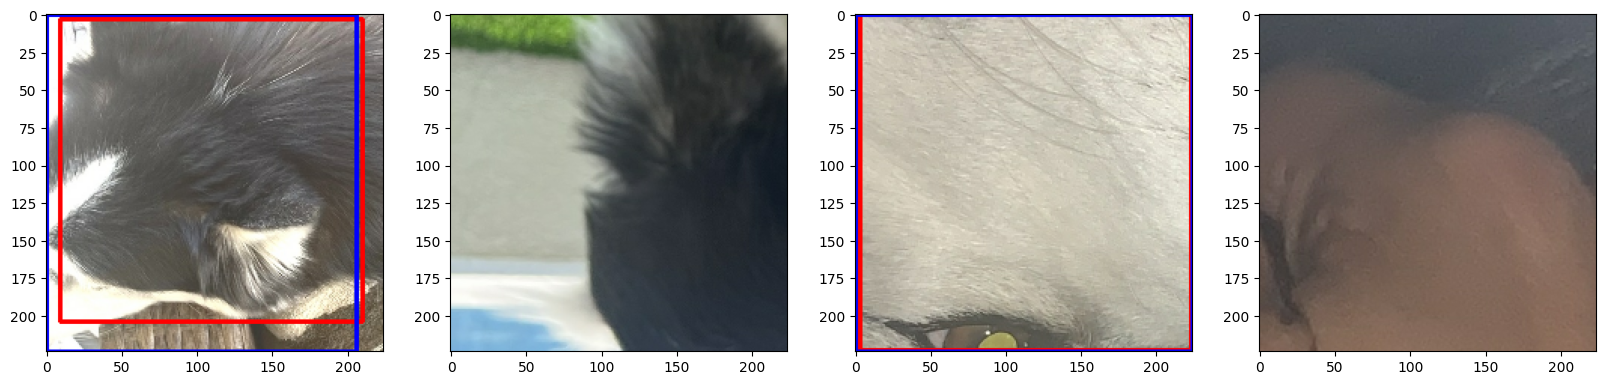

In [233]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    pred_coords = yhat[1][idx]
    true_coords = test_sample[1][1][idx]
    
    if yhat[0][idx] > 0.9:
        # Draw predicted bounding box in blue
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(pred_coords[:2], [w,h]).astype(int)),
                      tuple(np.multiply(pred_coords[2:], [w,h]).astype(int)), 
                            (255,0,0), 2)
        
        # Draw true bounding box in red
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(true_coords[:2], [w,h]).astype(int)),
                      tuple(np.multiply(true_coords[2:], [w,h]).astype(int)), 
                            (0,0,255), 2)
    
    ax[idx].imshow(sample_image)

In [234]:
from tensorflow.keras.models import load_model
from IPython.display import clear_output

In [235]:
bowietracker.save('bowietracker.h5')

In [236]:
bowietracker = load_model('bowietracker.h5')

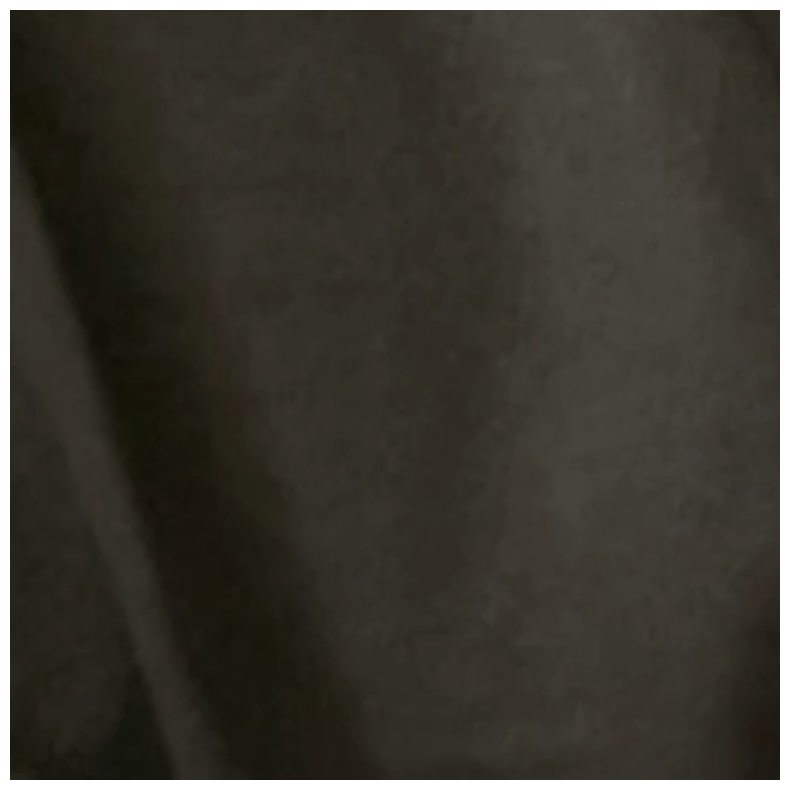

KeyboardInterrupt: 

In [238]:
cap = cv2.VideoCapture(1)

try:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            print("Failed to read frame from the camera. Exiting.")
            break

        frame = frame[50:500, 50:500, :]

        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resized = tf.image.resize(rgb, (w, h))

        yhat = bowietracker.predict(np.expand_dims(resized / 255, 0))
        sample_coords = yhat[1][0]

        if yhat[0] > 0.95:
            # Controls the main rectangle
            cv2.rectangle(frame,
                          tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                          tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)),
                          (255, 0, 0), 2)
            # Controls the label rectangle
            cv2.rectangle(frame,
                          tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                       [0, -30])),
                          tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                       [80, 0])),
                          (255, 0, 0), -1)

            # Controls the text rendered
            cv2.putText(frame, 'Bowie', tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                                   [0, -5])),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        # Display the frame in Jupyter Lab or Jupyter Notebook
        clear_output(wait=True)
        plt.figure(figsize=(10, 10))
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()

        # Press 'q' to quit
        # if cv2.waitKey(1) & 0xFF == ord('q'):
        #     break
finally:
    cap.release()
    # cv2.destroyAllWindows()

In [ ]:
!pip install opencv-python

In [98]:
#tests
test_images2 = tf.data.Dataset.list_files(['Other\\*.jpg','Other\\*.jpeg'], shuffle=False)
test_images2 = test_images2.map(load_image)
test_images2 = test_images2.map(lambda x: tf.image.resize(x, (w,h)))
test_images2 = test_images2.map(lambda x: x/255)


In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [w,h]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [w,h]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)